In [ ]:
 from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Đồ án"
!ls

/content/drive/MyDrive/Colab Notebooks/Đồ án
NLTK.ipynb  Spacy.ipynb  txt  Untitled0.ipynb


In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)


Tensorflow version: 2.12.0
GPU detected: []


In [ ]:
!pip install tensorflow==2.12

In [ ]:
data=pd.read_csv("ner_dataset.csv",encoding="latin1")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [ ]:
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [ ]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [ ]:
num_words, num_tags

(35179, 17)

In [ ]:
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [ ]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [ ]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [ ]:
word2idx

{'Male': 1,
 'anesthetist': 2,
 'food-borne': 3,
 'dispenses': 4,
 'deposit': 5,
 'sedimentary': 6,
 'directives': 7,
 'Mc': 8,
 'Al-Mukmin': 9,
 'restarted': 10,
 'Manshiyet': 11,
 'Hurriyah': 12,
 'Nayef': 13,
 'uninhabited': 14,
 'overruled': 15,
 'Asia': 16,
 'document': 17,
 'leisurely': 18,
 'Germany': 19,
 'braces': 20,
 'hitched': 21,
 'six-tenths': 22,
 'Bell': 23,
 'Sinmun': 24,
 'Elias': 25,
 'anti-apartheid': 26,
 'posing': 27,
 'CD': 28,
 'shake': 29,
 'Ui': 30,
 'auctioneers': 31,
 'pollsters': 32,
 'babe': 33,
 'McNeill': 34,
 'generous': 35,
 'deployments': 36,
 'Rodney': 37,
 'arbiter': 38,
 'ambition': 39,
 '11-style': 40,
 'dishes': 41,
 'affray': 42,
 'mm': 43,
 'TAAF': 44,
 'Yield': 45,
 'ablaze': 46,
 'increase': 47,
 'splintered': 48,
 'Jurors': 49,
 'concordat': 50,
 'tame': 51,
 'newspapers': 52,
 'anti-militant': 53,
 'Hilton': 54,
 'survey': 55,
 'bridge': 56,
 'prescription': 57,
 'none': 58,
 'Nunez': 59,
 'NORIEGA': 60,
 'gang-raped': 61,
 'interrogated': 

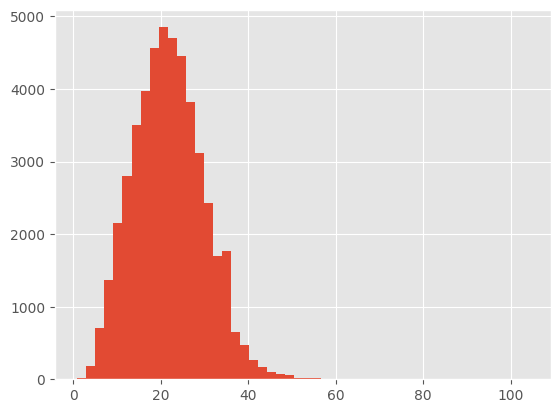

In [ ]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [ ]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

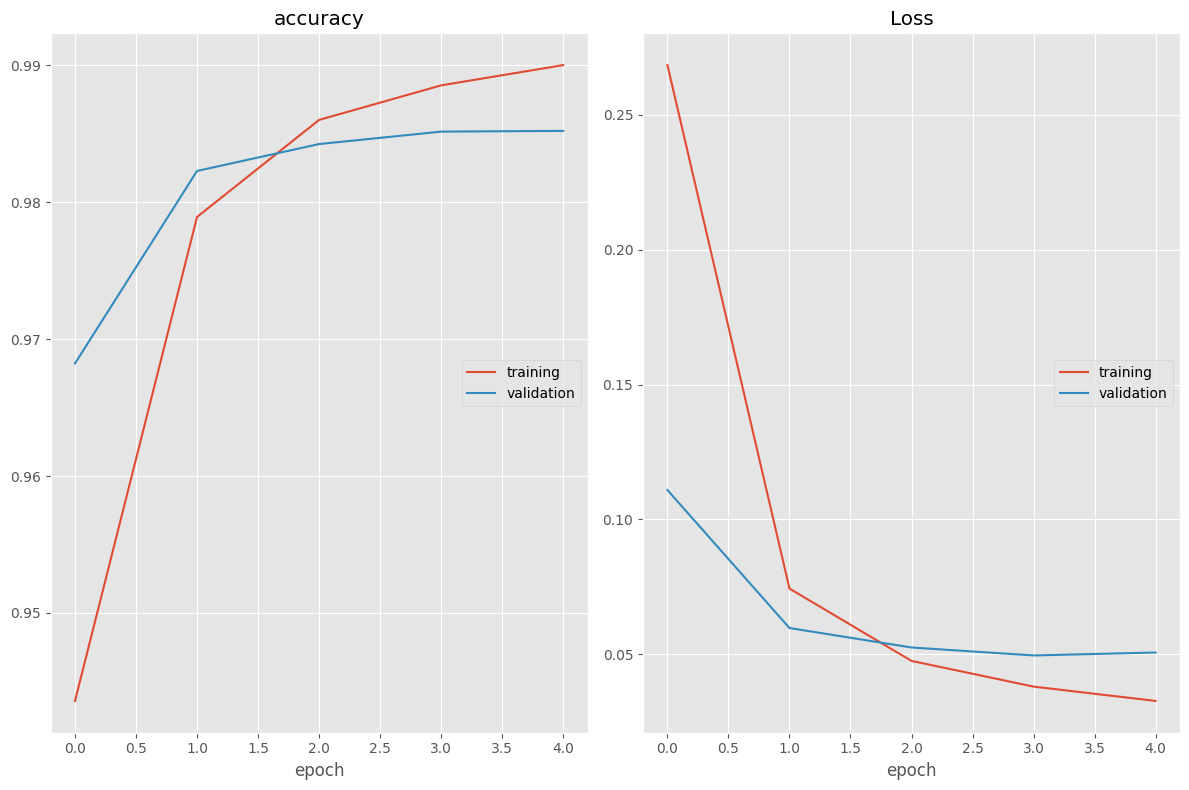

accuracy
	training         	 (min:    0.944, max:    0.990, cur:    0.990)
	validation       	 (min:    0.968, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.033, max:    0.268, cur:    0.033)
	validation       	 (min:    0.050, max:    0.111, cur:    0.051)
540/540 [==============================] - 184s 340ms/step - loss: 0.0327 - accuracy: 0.9900 - val_loss: 0.0506 - val_accuracy: 0.9852


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

In [ ]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 7s 48ms/step - loss: 0.0524 - accuracy: 0.9851


[0.05237775668501854, 0.9850708842277527]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

1/1 [==============================] - 1s 527ms/step
Word           True 	 Pred

------------------------------
The            O    	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O    	O
103            O    	O
nuclear        O    	O
power          O    	O
plants         O    	O
in             O    	O
31             O    	B-tim
states         O    	O
.              O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Vaccines       O    	O
Va